# Predict Employee Churn with Decision Trees and Random Forests

##Import Libraries


In [1]:
from __future__ import print_function
%matplotlib inline
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as image
import pandas as pd

!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip 
from pandas_profiling import ProfileReport

plt.style.use("ggplot")
warnings.simplefilter("ignore")

  Using cached https://github.com/pandas-profiling/pandas-profiling/archive/master.zip


In [2]:
plt.rcParams['figure.figsize'] = (12,8)

## Exploratory Data Analysis


In [3]:
#load data
hr = pd.read_csv('employee_data.csv')
hr.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,quit,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [4]:
#get info
hr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   quit                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [5]:
#rename for consistency
hr.rename(str.lower, axis='columns', inplace=True)

In [6]:
#get statistics
hr.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,work_accident,quit,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [13]:
#get profile report
profile = ProfileReport(hr, 
                        title='Employee Data', 
                        html={'style': {'full_width':True}})
profile

Summarize dataset:   0%|          | 0/23 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [14]:
#corr
hr.corr()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,work_accident,quit,promotion_last_5years
satisfaction_level,1.000000,0.105021,-0.142970,-0.020048,-0.100866,0.058697,-0.388375,0.025605
last_evaluation,0.105021,1.000000,0.349333,0.339742,0.131591,-0.007104,0.006567,-0.008684
number_project,-0.142970,0.349333,1.000000,0.417211,0.196786,-0.004741,0.023787,-0.006064
average_montly_hours,-0.020048,0.339742,0.417211,1.000000,0.127755,-0.010143,0.071287,-0.003544
time_spend_company,-0.100866,0.131591,0.196786,0.127755,1.000000,0.002120,0.144822,0.067433
work_accident,0.058697,-0.007104,-0.004741,-0.010143,0.002120,1.000000,-0.154622,0.039245
quit,-0.388375,0.006567,0.023787,0.071287,0.144822,-0.154622,1.000000,-0.061788
promotion_last_5years,0.025605,-0.008684,-0.006064,-0.003544,0.067433,0.039245,-0.061788,1.000000


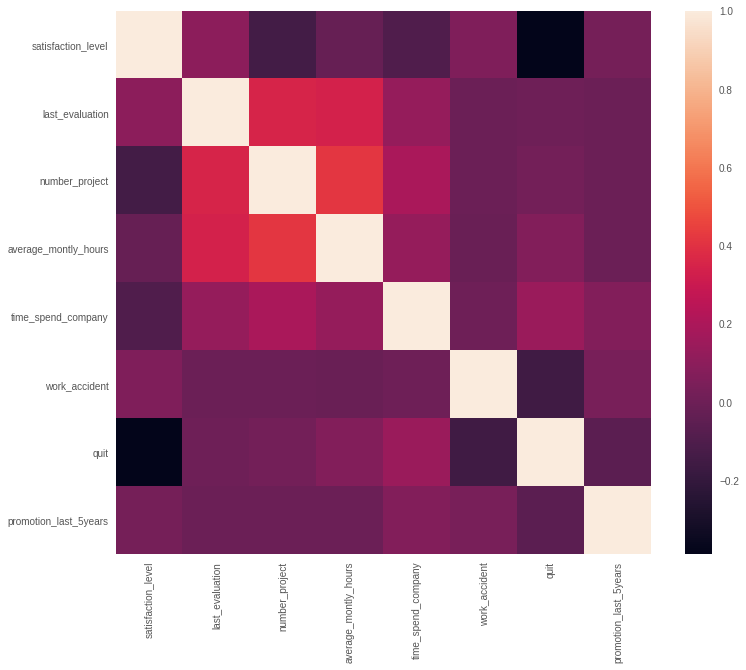

In [21]:
import seaborn as sns

#corr heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(hr.corr())

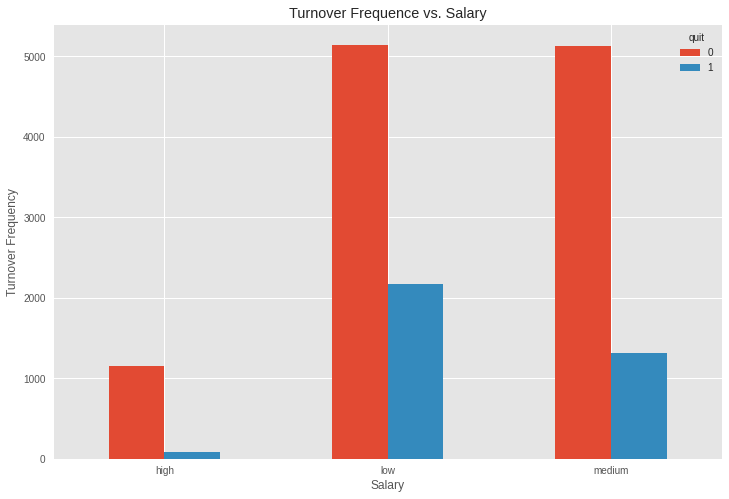

In [29]:
#crosstab to see how employees of different salary brackets behave
pd.crosstab(hr.salary, hr.quit).plot(kind='bar')
plt.title('Turnover Frequence vs. Salary')
plt.xlabel('Salary')
plt.ylabel('Turnover Frequency')
plt.xticks(rotation=0)
plt.show()

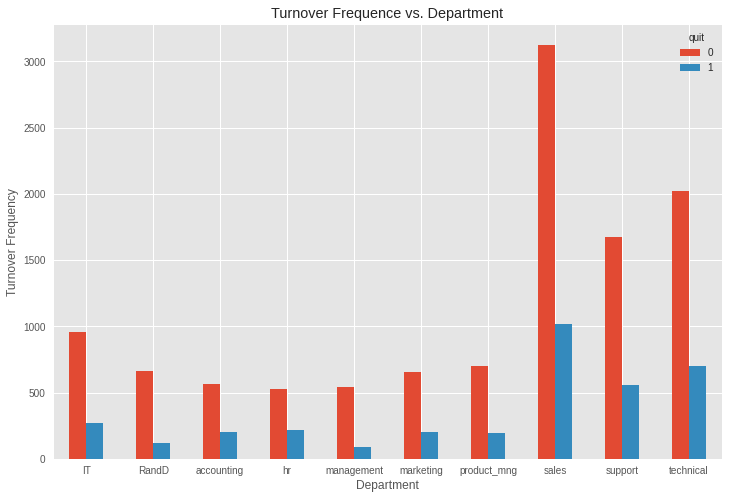

In [32]:
#crosstab to see how employees of different department behave
pd.crosstab(hr.department, hr.quit).plot(kind='bar')
plt.title('Turnover Frequence vs. Department')
plt.xlabel('Department')
plt.ylabel('Turnover Frequency')
plt.xticks(rotation=0)
plt.show()

## Encode Categorical Features


In [33]:
#one hot encoding
categorical_variables = ['department', 'salary']

for variable in categorical_variables:
  cat_list = pd.get_dummies(hr[variable], prefix='var')
  hr = hr.join(cat_list)

#view
hr.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,work_accident,quit,promotion_last_5years,department,salary,var_IT,var_RandD,var_accounting,var_hr,var_management,var_marketing,var_product_mng,var_sales,var_support,var_technical,var_high,var_low,var_medium
0,0.38,0.53,2,157,3,0,1,0,sales,low,0,0,0,0,0,0,0,1,0,0,0,1,0
1,0.80,0.86,5,262,6,0,1,0,sales,medium,0,0,0,0,0,0,0,1,0,0,0,0,1
2,0.11,0.88,7,272,4,0,1,0,sales,medium,0,0,0,0,0,0,0,1,0,0,0,0,1
3,0.72,0.87,5,223,5,0,1,0,sales,low,0,0,0,0,0,0,0,1,0,0,0,1,0
4,0.37,0.52,2,159,3,0,1,0,sales,low,0,0,0,0,0,0,0,1,0,0,0,1,0


In [34]:
hr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   work_accident          14999 non-null  int64  
 6   quit                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   department             14999 non-null  object 
 9   salary                 14999 non-null  object 
 10  var_IT                 14999 non-null  uint8  
 11  var_RandD              14999 non-null  uint8  
 12  var_accounting         14999 non-null  uint8  
 13  var_hr                 14999 non-null  uint8  
 14  var_management         14999 non-null  uint8  
 15  va

In [35]:
#drop columns that were ohe
hr.drop(columns=['department', 'salary'], axis=1, inplace=True)
hr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   work_accident          14999 non-null  int64  
 6   quit                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   var_IT                 14999 non-null  uint8  
 9   var_RandD              14999 non-null  uint8  
 10  var_accounting         14999 non-null  uint8  
 11  var_hr                 14999 non-null  uint8  
 12  var_management         14999 non-null  uint8  
 13  var_marketing          14999 non-null  uint8  
 14  var_product_mng        14999 non-null  uint8  
 15  va

## Visualize Class Imbalance


In [44]:
from yellowbrick.target import ClassBalance
plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = (12, 8)

ClassBalance(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f1c512c69d0>,
             labels=['stayed', 'quit'])

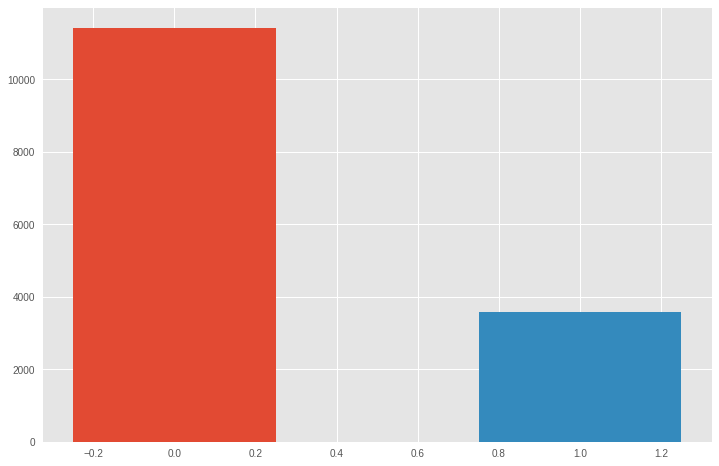

In [45]:
#initialize
visualizer = ClassBalance(labels=['stayed', 'quit'])

#fit
visualizer.fit(hr.quit)

## Create Training and Test Sets


In [46]:
#define X
X = hr.drop(columns=['quit'], axis=1)
y = hr['quit']

In [47]:
from sklearn.model_selection import train_test_split

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, 
                                                    random_state=0,
                                                    stratify=y)

## Build an Interactive Decision Tree Classifier

Supervised learning: 
- The inputs are random variables $X = X_1, ..., X_p$;
- The output is a random variable $Y.$

- Data is a finite set $$\mathbb{L}=\{(x_i,y_i)|i=0, ..., N-1\}$$
where $x_i \in X = X_1 \times ... \times X_p$ and $y_i \in y$ are randomly drawn from $P_{X,Y}.$

E.g., $(x_i,y_i)=((\text{salary = low, department = sales, ...}),\text{quit = 1})$

- The goal is to find a model $\varphi_\mathbb{L}: X \mapsto y$ minimizing $$\text{Err}(\varphi_\mathbb{L}) = \mathbb{E}_{X,Y}\{L(Y, \varphi_\mathbb{L}(X))\}.$$

About:
 
 - Decision trees are non-parametric models which can model arbitrarily complex relations between inputs and outputs, without any a priori assumption
 
- Decision trees handle numeric and categorical variables

- They implement feature selection, making them robust to noisy features (to an extent)

- Robust to outliers or errors in labels

- Easily interpretable by even non-ML practioners.

#### Decision trees: partitioning the feature space:



- Decision trees generally have low bias but have high variance.
- We will solve the high variance problem in Task 8.

In [48]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz # display the tree within a Jupyter notebook
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from ipywidgets import interactive, IntSlider, FloatSlider, interact
import ipywidgets
from IPython.display import Image
from subprocess import call
import matplotlib.image as mpimg

In [73]:
@interact
def plot_tree(crit=['gini', 'entropy'],
              split=['best', 'random'],
              depth=IntSlider(min=1,
                              max=30,
                              value=2, 
                              continuous_update=False),
              min_split=IntSlider(min=1,
                                  max=5,
                                  value=2, 
                                  continuous_update=False),
              min_leaf=IntSlider(min=1,
                                 max=5,
                                 value=1, 
                                 continuous_update=False)):
    
    #initialize clf
    estimator = DecisionTreeClassifier(random_state=0,
                                       criterion=crit,
                                       splitter=split,
                                       max_depth=depth,
                                       min_samples_split=min_split,
                                       min_samples_leaf=min_leaf)
    
    #fit
    estimator.fit(X_train, y_train)

    #get metrics
    print('Decision Tree training accuracy: {:.3f}'.format(accuracy_score(y_train, estimator.predict(X_train))))
    print('Decision Tree test accuracy: {:.3f}'.format(accuracy_score(y_test, estimator.predict(X_test))))

    #graph
    graph = Source(tree.export_graphviz(estimator, 
                                        out_file=None, 
                                        feature_names=X_train.columns,
                                        class_names=['stayed', 'quit'],
                                        filled=True))
    
    #display
    display(Image(data=graph.pipe(format='png')))

    return estimator

interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…

## Build an Interactive Random Forest Classifier
 

Although randomization increases bias, it is possible to get a reduction in variance of the ensemble. Random forests are one of the most robust machine learning algorithms for a variety of problems.

- Randomization and averaging lead to a reduction in variance and improve accuracy
- The implementations are parallelizable
- Memory consumption and training time can be reduced by bootstrapping
- Sampling features and not solely sampling examples is crucial to improving accuracy

In [72]:
@interact
def plot_tree_rf(crit=['gini', 'entropy'],
                 bootstrap=['True', 'False'],
                 depth=IntSlider(min=1,
                                 max=30,
                                 value=3, 
                                 continuous_update=False),
                 forests=IntSlider(min=1,
                                   max=200,
                                   value=100,
                                   continuous_update=False),
                 min_split=IntSlider(min=2,
                                     max=5,
                                     value=2, 
                                     continuous_update=False),
                 min_leaf=IntSlider(min=1,
                                    max=5,
                                    value=1, 
                                    continuous_update=False)):
  
  #initialize
  estimator = RandomForestClassifier(random_state=0,
                                     criterion=crit,
                                     bootstrap=bootstrap,
                                     n_estimators=forests,
                                     max_depth=depth,
                                     min_samples_split=min_split,
                                     min_samples_leaf=min_leaf,
                                     n_jobs=-1,
                                     verbose=False)
    
  #fit
  estimator.fit(X_train, y_train)

  #get metrics
  print('Random Forest training accuracy: {:.3f}'.format(accuracy_score(y_train, estimator.predict(X_train))))
  print('Random Forest test accuracy: {:.3f}'.format(accuracy_score(y_test, estimator.predict(X_test))))

  #display only first tree
  num_tree = estimator.estimators_[0]

  print('Visualizing Tree #1')
  #graph
  graph = Source(tree.export_graphviz(num_tree,
                                      out_file=None,
                                      feature_names=X_train.columns,
                                      class_names=['stayed', 'quit'],
                                      filled=True))
    
  #display
  display(Image(data=graph.pipe(format='png')))

  return estimator
    

interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…

## Feature Importance and Evaluation Metrics


In [71]:
from yellowbrick.features import FeatureImportances

plt.rcParams['figure.figsize'] = (12,8)
plt.style.use("ggplot")

FeatureImportances(absolute=False,
                   ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f1c5b3fb350>,
                   labels=None, model=None, relative=True, stack=False,
                   xlabel=None)

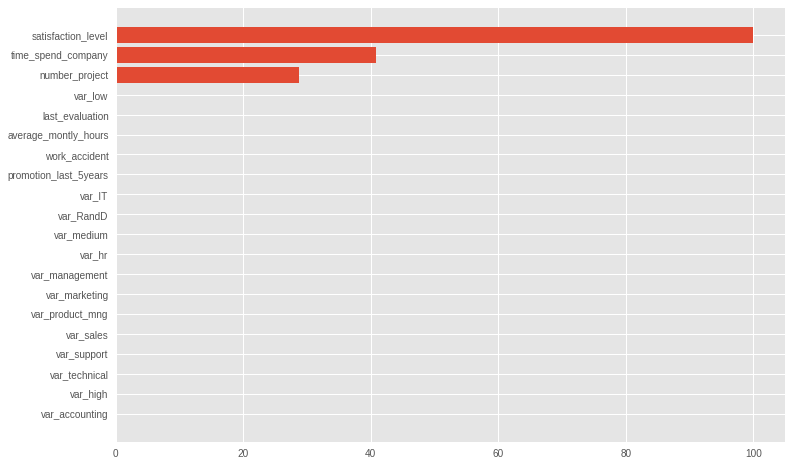

In [77]:
#decision tree
dt = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

#get feature importance
viz = FeatureImportances(dt)
viz.fit(X_train, y_train)

FeatureImportances(absolute=False,
                   ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f1c4e827d10>,
                   labels=None, model=None, relative=True, stack=False,
                   xlabel=None)

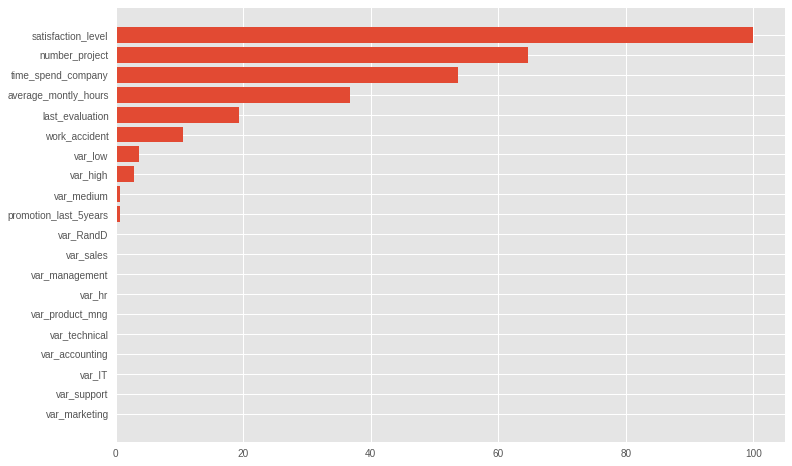

In [76]:
#random forest classifier
rf = RandomForestClassifier(bootstrap='True', ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0,
                       verbose=False, warm_start=False)

#get feature importance
viz = FeatureImportances(rf)
viz.fit(X_train, y_train)

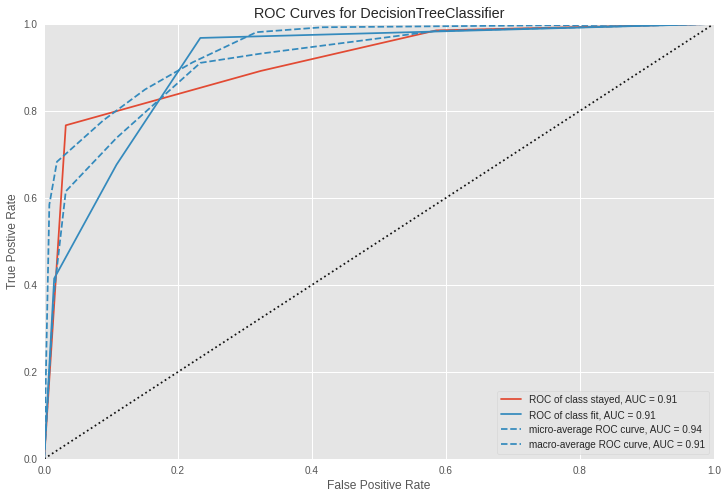

In [81]:
from yellowbrick.classifier import ROCAUC

#get ROC curve of decision tree
visualizer = ROCAUC(dt, classes=['stayed', 'fit'])
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof();

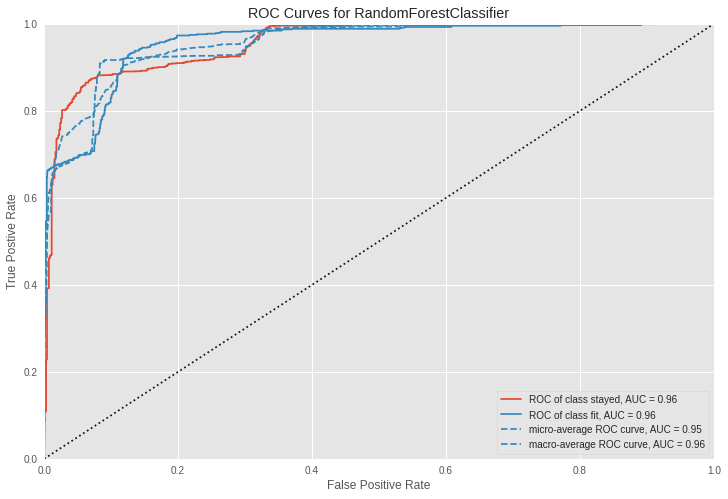

In [80]:
#get ROC curve of random forest
visualizer = ROCAUC(rf, classes=['stayed', 'fit'])
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof();